In [0]:
!pip install tensorflow==2.0.0b1

     |████████████████████████████████| 87.9MB 1.1MB/s 
     |████████████████████████████████| 3.1MB 29.1MB/s 
     |████████████████████████████████| 501kB 32.7MB/s 
  Found existing installation: tensorflow 1.14.0
    Uninstalling tensorflow-1.14.0:
      Successfully uninstalled tensorflow-1.14.0


In [0]:
import tensorflow as tf
print(tf.__version__)

2.0.0-beta1


In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid (True)

In [5]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2019-10-01 15:04:24--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.008s  

2019-10-01 15:04:24 (8.57 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



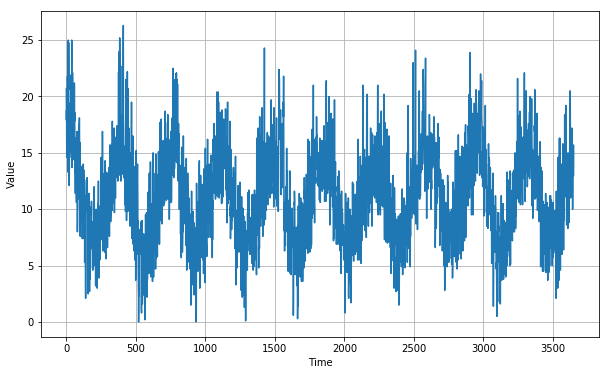

In [7]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for i,row in enumerate(reader):
    temps.append(float(row[1]))
    time_step.append(i)

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000



In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda x: x.batch(window_size+1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda x: (x[:-1], x[1:]))
    ds = ds.batch(batch_size).prefetch(1)
    
    return ds 

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda x: x.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forcast = model.predict(ds)
    return forcast 

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='causal', activation=tf.nn.relu, input_shape=[None,1]),
tf.keras.layers.LSTM(64, return_sequences=True),    
tf.keras.layers.LSTM(64, return_sequences=True), 
tf.keras.layers.Dense(60, activation='relu'),
tf.keras.layers.Dense(30, activation='relu'),
tf.keras.layers.Dense(1),
tf.keras.layers.Lambda(lambda x: x*30)    
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])




<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 7s 732ms/step - loss: 9.1502 - mae: 9.6535
Epoch 2/100
10/10 [==============================] - 5s 454ms/step - loss: 9.1436 - mae: 9.6466
Epoch 3/100
10/10 [==============================] - 5s 457ms/step - loss: 9.1330 - mae: 9.6360
Epoch 4/100
10/10 [==============================] - 4s 447ms/step - loss: 9.1201 - mae: 9.6231
Epoch 5/100
10/10 [==============================] - 5s 450ms/step - loss: 9.1054 - mae: 9.6084
Epoch 6/100
10/10 [==============================] - 4s 450ms/step - loss: 9.0888 - mae: 9.5917
Epoch 7/100
10/10 [==============================] - 5s 453ms/step - loss: 9.0701 - mae: 9.5731
Epoch 8/100
10/10 [==============================] - 4s 449ms/step - loss: 9.0493 - mae: 9.5523
Epoch 9/100
10/10 [==============================] - 5s 461ms/step - loss: 9.0261 - mae: 9.5290
Epoch 10/100
10/10 [==============

[1e-08, 0.0001, 0, 60]

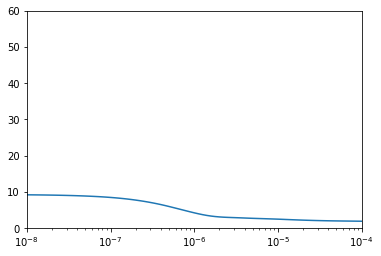

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='causal', activation='relu', input_shape=[None,1]),
  tf.keras.layers.LSTM(64, return_sequences=True), 
  tf.keras.layers.LSTM(64, return_sequences=True), 
  tf.keras.layers.Dense(60, activation='relu'),
  tf.keras.layers.Dense(30, activation='relu'),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x*30)  
])


optimizer = tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=30)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/30
25/25 [==============================] - 8s 316ms/step - loss: 3.7826 - mae: 4.2908
Epoch 2/30
25/25 [==============================] - 5s 208ms/step - loss: 2.1106 - mae: 2.5695
Epoch 3/30
25/25 [==============================] - 5s 206ms/step - loss: 1.8964 - mae: 2.3498
Epoch 4/30
25/25 [==============================] - 5s 206ms/step - loss: 1.8457 - mae: 2.2983
Epoch 5/30
25/25 [==============================] - 5s 208ms/step - loss: 1.8195 - mae: 2.2715
Epoch 6/30
25/25 [==============================] - 5s 210ms/step - loss: 1.7990 - mae: 2.2507
Epoch 7/30
25/25 [==============================] - 5s 210ms/step - loss: 1.7792 - mae: 2.2305
Epoch 8/30
25/25 [==============================] - 5s 205ms/step - loss: 1.7622 - mae: 2.2129
Epoch 9/30
25/25 [==============================] - 5s 209ms/step - loss: 1.7459 - mae: 2.1962
Epoch 10/30
25/25 [==============================] - 5s 210ms/step - loss: 1.7311 - mae: 2.1805
Epoch 11/30
25/25 [==============================

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

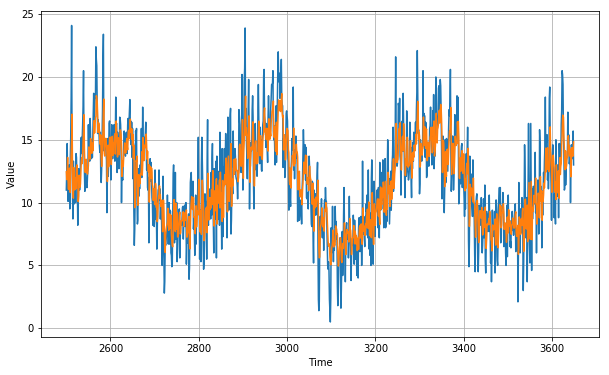

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()



1.7950386

In [0]:
print(rnn_forecast)


[12.449251  11.832415  12.48754   ... 13.6862135 13.738639  14.840612 ]
